# Rainy Lake Water Levels

The purpose of this notebook is to create a data series for the water level on Rainy Lake. The data series is written to a file `RL.pkl` that can be read into other notebooks using `RL = pd.read_pickle('/data/RL.pkl')`.

The data series is constructed using data from stations 05PB007 and 05PB024 from the Water Survey of Canada. The data from the two stations are reconciled and combined to form a unique data series.

## Read Data from Water Survey of Canada

The Water Survey of Canada currently maintains two stations on Rainy Lake recording lake levels. Station 05PB007, located near Fort Frances, has been in place since 1911. The other, near Bear Pass, has been in operation since 1988. 

The data set is imported into the workspace by running the Water Survey of Canada notebook.

In [1]:
# Display graphics inline with the notebook
%matplotlib inline

# Standard Python modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime

import seaborn as sns
sns.set_context('talk')

# Modules to display images and data tables
from IPython.display import Image
from IPython.core.display import display
import requests

WSC_STATIONS = pd.read_pickle('../data/WSC_STATIONS')
WSC_LEVELS = pd.read_pickle('../data/WSC_LEVELS')

def mapWSC(stationList):
    # returns a .png map image
    S = WSC_STATIONS.ix[stationList,['STATION_NAME','LATITUDE','LONGITUDE']]
    locs = ["{0},{1}".format(S.ix[s,'LATITUDE'], S.ix[s,'LONGITUDE']) \
             for s in S.index]
    google_maps_url = \
        "https://maps.googleapis.com/maps/api/staticmap?" + \
        "size=640x320" + \
        "&maptype=terrain" + \
        "&markers=color:red%7Csize:mid%7C" + "|".join(locs)
    display(S)
    return Image(requests.get(google_maps_url).content)

,STATION_NAME,LATITUDE,LONGITUDE
STATION_NUMBER,,,
05PB007,RAINY LAKE NEAR FORT FRANCES,48.64912,-93.32068
05PB024,RAINY LAKE NEAR BEAR PASS,48.70058,-92.95800


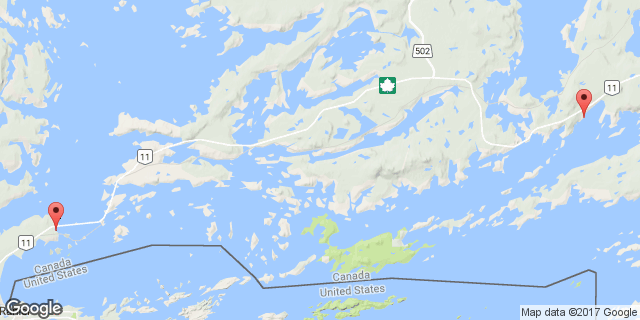

In [2]:
ff = '05PB007'
bp = '05PB024'
mapWSC([ff,bp])

## The Need for Data Reconciliation

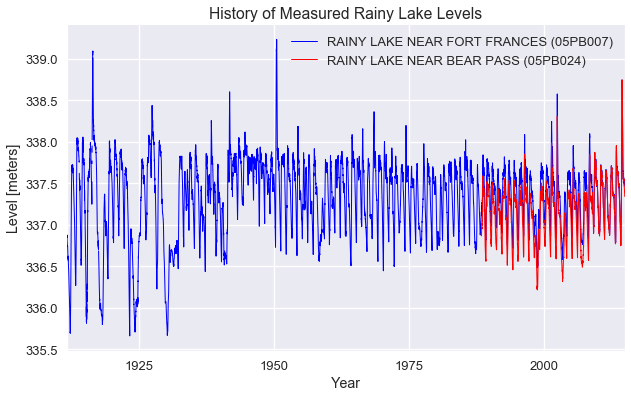

In [3]:
plt.figure(figsize=(10,6))
WSC_LEVELS[ff].plot(color='blue',lw=1)
WSC_LEVELS[bp].plot(color='red',lw=1)
plt.legend([WSC_STATIONS.ix[ff,'STATION_NAME'] + ' (' + ff + ')',
            WSC_STATIONS.ix[bp,'STATION_NAME'] + ' (' + bp + ')'])
plt.xlabel('Year')
plt.ylabel('Level [meters]')
plt.title('History of Measured Rainy Lake Levels');

There's an obvious difference between the lake level measured at Fort Frances and at Bear Pass in the period from 1988 to 2009. The level sensor at Bear Pass (05PB024) shows a systematic deviation from the historical data near Fort Frances. Let's look take a more careful look.

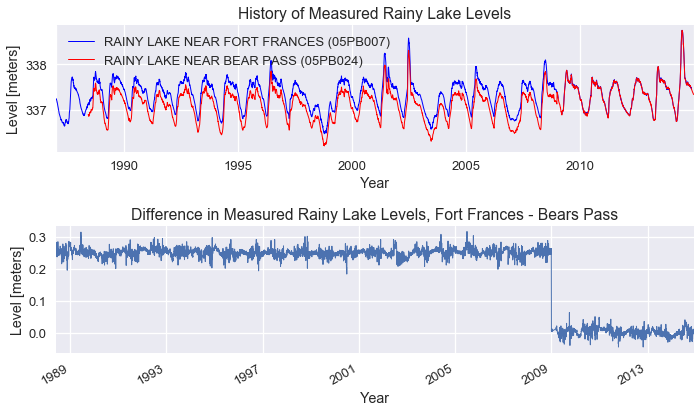

In [4]:
plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
WSC_LEVELS[ff]['1987':].plot(color='blue',lw=1)
WSC_LEVELS[bp]['1987':].plot(color='red',lw=1)
plt.legend([WSC_STATIONS.ix[ff,'STATION_NAME'] + ' (' + ff + ')',
            WSC_STATIONS.ix[bp,'STATION_NAME'] + ' (' + bp + ')'])
plt.xlabel('Year')
plt.ylabel('Level [meters]')
plt.title('History of Measured Rainy Lake Levels');

plt.subplot(2,1,2)
dR = WSC_LEVELS[ff]['1987':] - WSC_LEVELS[bp]['1987':]
dR = dR[dR.notnull()]
dR.plot(lw=1)
plt.xlabel('Year')
plt.ylabel('Level [meters]')
plt.title('Difference in Measured Rainy Lake Levels, Fort Frances - Bear''s Pass');

plt.tight_layout()

The abrupt change at the beginning of 2009 appears to be a recalibration of the Bear Pass level sensor. To reconcile the level measurements, we find the mean level difference pre- and post- the 2009 change, then add that difference to the levels reported from Bear Pass prior to 2009.

Average Sensor Differences:
     Pre Adjustment:  25.19  centimeters
     Post Adjustment:  0.387  centimeters


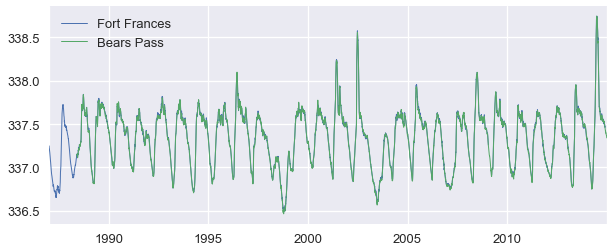

In [5]:
plt.figure(figsize=(10,4))

# find the point at which there is a big shift
t  = (dR - dR.shift(1)).argmin()

# find average differences before and after the shift
preAdj = dR[:t][:-1].mean()
postAdj = dR[t:].mean()

print("Average Sensor Differences:")
print("     Pre Adjustment: ", round(100*preAdj,2), " centimeters")
print("     Post Adjustment: ", round(100*postAdj,3), " centimeters")

# adjust the Bear Pass sensor to have the same mean offset 
# before the shift as after the shift
BP = WSC_LEVELS[bp].copy()
BP[:t][:-1] += preAdj - postAdj

WSC_LEVELS[ff]['1987':].plot(lw=1)
BP['1987':].plot(lw=1)
plt.legend(['Fort Frances','Bear''s Pass'])

There may be a sustained and systematic difference lake level between sensors spaced about 27 km apart due to sustained winds or flow. In this case, however, it is difficult to determine what that difference would be, or if the sensors were calibrated precisely to the same datum or to the same average lake level. For those reasons, we adjust the average level recorded at the Bear's Pass station to the average level recorded at Fort Frances for the same period of time.

In [6]:
# locate start of BP data series
t1 = BP.dropna().index[0]
t2 = min(WSC_LEVELS[ff].dropna().index[-1],BP.dropna().index[-1])

BP = BP - BP[t1:t2].mean() + WSC_LEVELS[ff][t1:t2].mean()

print(BP.mean())
print(WSC_LEVELS[ff].mean())

337.3518103275223
337.33175300787565


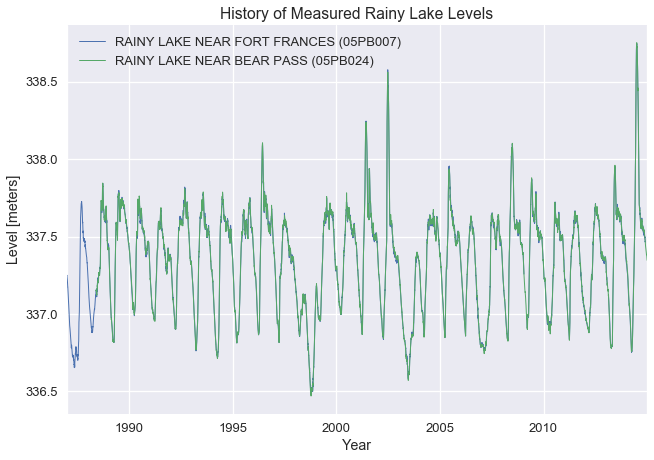

In [7]:
WSC_LEVELS[ff]['1987':].plot(lw=1)
BP['1987':].plot(lw=1)
plt.legend([WSC_STATIONS.ix[ff,'STATION_NAME'] + ' (' + ff + ')',
            WSC_STATIONS.ix[bp,'STATION_NAME'] + ' (' + bp + ')'])
plt.xlabel('Year')
plt.ylabel('Level [meters]')
plt.title('History of Measured Rainy Lake Levels');

We finish by combining the adjusted sensor data into a single time series for the level of Rainy Lake. The mean value of the B

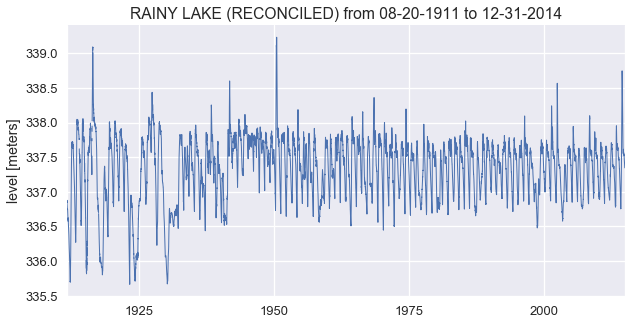

In [8]:
RL = pd.Series(pd.concat([WSC_LEVELS[ff],BP],axis=1).mean(axis=1))
RL.name = 'RAINY LAKE (RECONCILED)'

fig,ax = plt.subplots(1,1,figsize=(10,5))
RL.plot(lw=1)
plt.ylabel('level [meters]')
plt.title(RL.name \
          + ' from ' + RL.index.min().strftime('%m-%d-%Y') \
          + ' to ' + RL.index.max().strftime('%m-%d-%Y'))

## Writing the Rainy Lake Level Data Series to a File

The reconciled historical levels for Rainy Lake are stored in a Pandas Series `RL` and pickled to a file `RL.pkl` for use in other calculations.

In [9]:
RL.to_pickle('../data/RL.pkl')
RL.head()

1911-08-20    336.868
1911-08-21    336.880
1911-08-22    336.865
1911-08-23    336.853
1911-08-24    336.844
Freq: D, Name: RAINY LAKE (RECONCILED), dtype: float64

In addition, the following cell writes a .csv file `RLstage.csv` where dates are encoded as datenun using the Matlab convention. This file can be read in Matlab and used for Simulink simulations of control policies.

In [10]:
RLstage = pd.DataFrame(RL)
RLstage['datenum'] = (RL.index - datetime.datetime(1900,1,1)).days + 693962.0
RLstage.to_csv('../data/RLstage.csv')
print(RLstage.head())

# test the 
RLstage.ix[datetime.datetime(1969,12,31)]

            RAINY LAKE (RECONCILED)   datenum
1911-08-20                  336.868  698210.0
1911-08-21                  336.880  698211.0
1911-08-22                  336.865  698212.0
1911-08-23                  336.853  698213.0
1911-08-24                  336.844  698214.0


RAINY LAKE (RECONCILED)       337.395
datenum                    719528.000
Name: 1969-12-31 00:00:00, dtype: float64

## Statistical Properties of the Level Sensors

The availability of two sensors provides an opportunity to estimate noise associated with a typical level measurement. Here we attempt to characterize the measurement noise using the signal $d(k)$ for the difference in level measurements between the Fort Frances and Bear's Pass monitoring stations.

Although the sensors are located on the same body of water, they are approximately 27 km apart therefore introducing the possibility of sustained differences due to hydrology, persistent wind or water flow patterns, systematic measurement bias, or miscalibration of the sensor datums. For these reasons, we following a multi-step procedure to isolate an estimate of measurement noise:

1. Detrend $d(k)$ to form $\tilde{d}(k)$ with zero mean with no linear trend.
2. Confirm $\tilde{d}(k)$ passes routine tests for a stationary time-series.
3. Remove auto-regressive components of $\tilde{d}(k)$ which are assumed to be due to lake and watershed dynamics.
4. Confirm the remaining residuals passes routine inspection as an independent, identically distributed source of measurement noise.

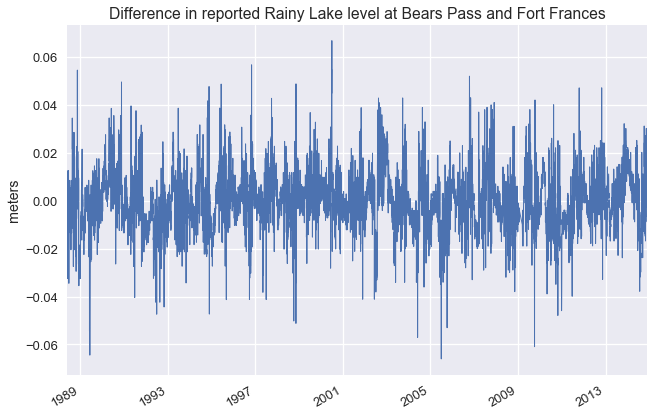

In [26]:
# d is the difference between the level sensor at Bear's Pass and Fort Frances
d = (BP - WSC_LEVELS[ff]).dropna()

# detrend
from scipy.signal import detrend
d = pd.Series(detrend(d.values),index=d.index,name='Level Difference BP-FF')

# plot
d.plot(lw=1)
plt.ylabel('meters')
plt.title('Difference in reported Rainy Lake level at Bear''s Pass and Fort Frances')

### Tests for Stationarity

#### Augmented Dickey-Fuller Test

The augmented Dickey-Fuller (adf) test is a tool for testing whether a time series possesses a unit root and would therefore be non-stationary. ad is a hypothesis test where the null (H0) is the existence of a unitroot. A p-value less that 0.05 indicates that we can reject the hyptothesis of a unit root with less than 5% probability of a type 1 error.

In [27]:
from statsmodels.tsa.stattools import acf, adfuller

r = adfuller(d)
print("ADF Statistic:", r[0])
print("p-value:", r[1])
print('Critical Values:')
for key, value in r[4].items():
    print('\t{0:>4s}: {1:.3f}'.format(key, value))


ADF Statistic: -11.092848873
p-value: 4.04147670221e-20
Critical Values:
	  1%: -3.431
	  5%: -2.862
	 10%: -2.567


The data set appears to have no unit roots.

### Correlation Analysis

Next we test for autocorrelation in the difference between the level measurements at the two stations.

The Durbin-Watson statistic provides a basic test for autocorrelation.

In [28]:
import statsmodels.api as sm
print("Durbin-Watson Statistic = ", round(sm.stats.durbin_watson(d),4))

Durbin-Watson Statistic =  0.566


A value of 2 for the Durbin-Watson statistic corresponds to no autocorrelation, with values in the range 1.5 to 2.5 taken to be generally 'normal'. In this case the statistic has a value of 0.57 suggesting positive autocorrelation.

Plotting the autocorrelation are partial autocorrelation verifies this conclusion.

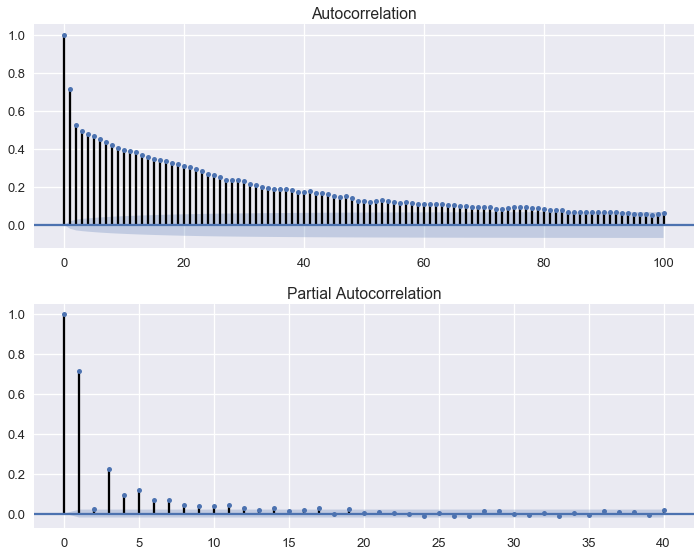

In [29]:
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(d.values.squeeze(), lags=100, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(d, lags=40, ax=ax2)

plt.tight_layout()

A lag plot further demonstrates the positive correlation evident in the differences between level measurements.

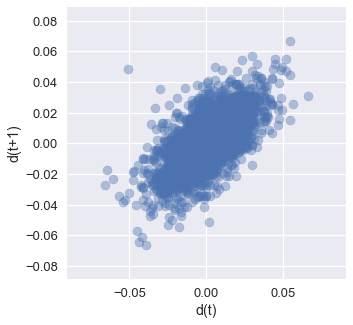

In [30]:
# lag plots
plt.figure(figsize=(5,5))
pd.tools.plotting.lag_plot(d,alpha=0.4)
plt.axis('equal')
plt.xlabel('d(t)')
plt.ylabel('d(t+1)')

The evident temporal correlations evident suggests the difference in level measurements at the two stations is confounded by lake dynamics. We will attempt to model the dynamics using an ARMA model of the form

$$d(k) = a_1 d(k-1) + a_2 d(k-2) + e(k) + b_1 e(k-1) + b_2 e(k-2)$$

                            Results: ARMA
Model:              ARMA             BIC:                 -66181.1402
Dependent Variable: y                Log-Likelihood:      33118.     
Date:               2017-06-10 14:18 Scale:               1.0000     
No. Observations:   9607             Method:              css-mle    
Df Model:           5                Sample:              0          
Df Residuals:       9602                                  7          
Converged:          1.0000           S.D. of innovations: 0.008      
AIC:                -66224.1617      HQIC:                -66209.570 
-----------------------------------------------------------------------
              Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
-----------------------------------------------------------------------
const         0.0000     0.0007     0.0022   0.9983   -0.0014    0.0014
ar.L1.y       1.0689     0.0291    36.6732   0.0000    1.0118    1.1261
ar.L2.y      -0.0944     0.0273    -3.

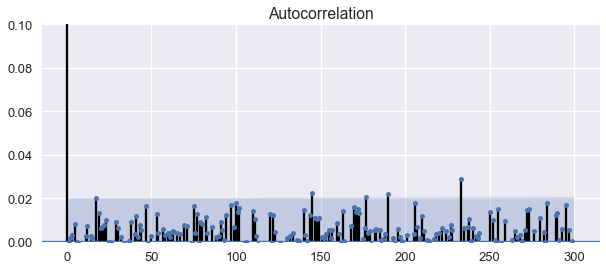

In [31]:
model = sm.tsa.ARMA(d.values, (2,2))
arma_mod = sm.tsa.ARMA(d.values, (2,2)).fit()
print(arma_mod.summary2())

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(111)
fig = sm.graphics.tsa.plot_acf(arma_mod.resid, lags=300, ax=ax1)
plt.ylim(0,.1)

print(sm.stats.durbin_watson(arma_mod.resid))

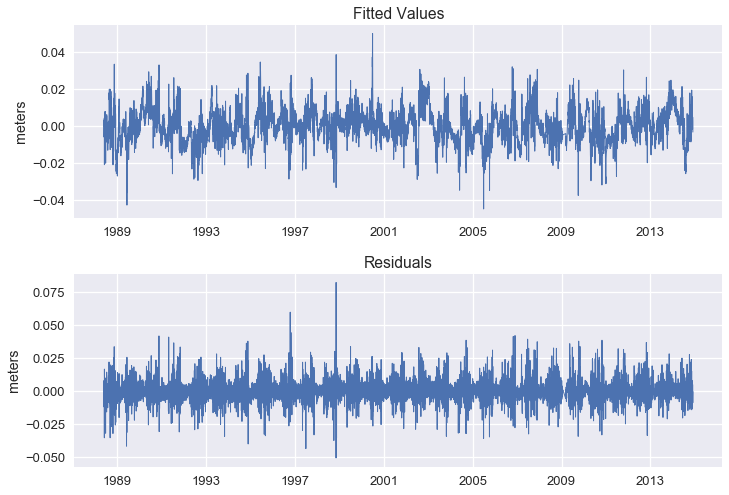

In [32]:
p = pd.Series(arma_mod.fittedvalues,index=d.index)
e = pd.Series(arma_mod.resid,index=d.index)

plt.subplot(2,1,1)
plt.plot(p,lw=1)
plt.title('Fitted Values')
plt.ylabel('meters')

plt.subplot(2,1,2)
plt.plot(e,lw=1)
plt.title('Residuals')
plt.ylabel('meters')

plt.tight_layout()

### Test for Stationarity

#### Lag Plots

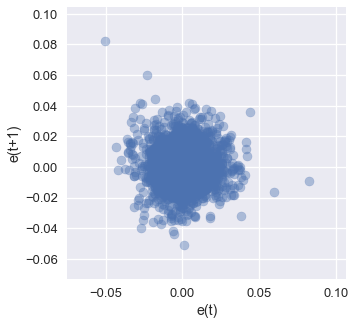

In [48]:
# lag plots
plt.figure(figsize=(5,5))
pd.tools.plotting.lag_plot(e,alpha=0.4)
plt.axis('equal')
plt.xlabel('e(t)')
plt.ylabel('e(t+1)')

#### Comparing First and Second Halves of the Data Set

A second test is to split the data set into halves, then test if the distribution of the first half is statistically different from the distribution of the second half.

In [49]:
from scipy.stats.kde import gaussian_kde
from scipy.signal import detrend

n2 = round(len(e)/2)

e1 = detrend(e[:n2])
e2 = detrend(e[n2:])

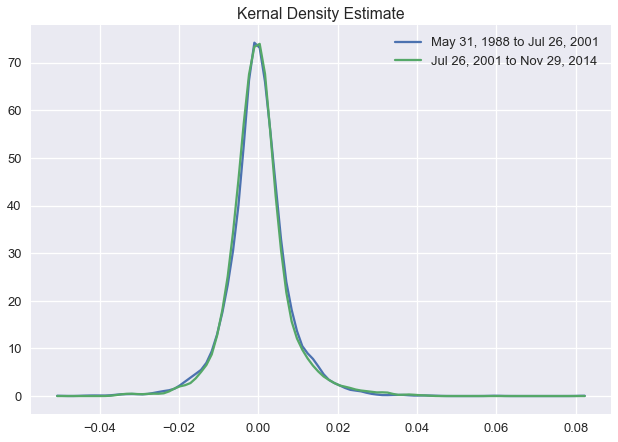

In [50]:
kde1 = gaussian_kde(e1)
kde2 = gaussian_kde(e2)

def datefrmt(d):
    return d.strftime("%b %d, %Y")

t0 = e.index[0]
t1 = e.index[n2]
t2 = e.index[-1]

dist_space = np.linspace( min(e), max(e), 100 )
plt.plot(dist_space, kde1(dist_space), dist_space, kde2(dist_space))
plt.title('Kernal Density Estimate')
p1 = '{0:} to {1:}'.format(datefrmt(t0),datefrmt(t1))
p2 = '{0:} to {1:}'.format(datefrmt(t1),datefrmt(t2))
plt.legend([p1,p2],loc='upper right')

#### Kolmogorov-Smirnov statistic

Given two samples, the Kolmogorov-Smirnov (KS) statistic is a two-sided test for the null hypothesis that the samples are drawn from the same distribution.  When the KS statistic is small, or the p-value high, we cannot reject the hypothesis that the distribution of the two samples is the same.

In [51]:
from scipy.stats import ks_2samp
ks_2samp(e1,e2)

Ks_2sampResult(statistic=0.025887147621274031, pvalue=0.078706339341129708)

The p-value would have to be less then 0.05 to reject the hypothesis that these samples are drawn from the same distribution at the 95% confidence interval.

#### Test for normality of the residuals.

In [377]:
from scipy.stats import normaltest
normaltest(resid)

NormaltestResult(statistic=1386.5025709937495, pvalue=8.4099252635399581e-302)

The extremely small p-value provides strong evidence that the residuals are not normal.  We can confirm this result with a qqplot.

#### qqplot

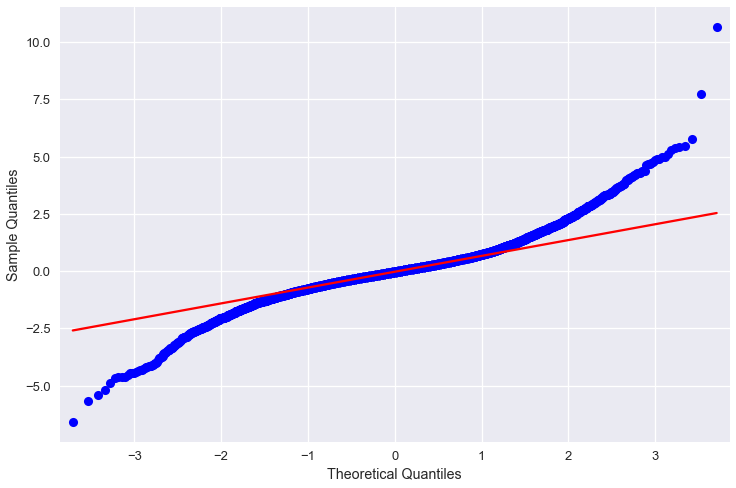

In [119]:
from statsmodels.graphics.api import qqplot

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(e, line='q', ax=ax, fit=True)

#### Fitting a Normal Distribution

-1.52370295794e-07 0.00770218961325
Location =  -0.0 centimeters
Scale =  0.77 centimeters


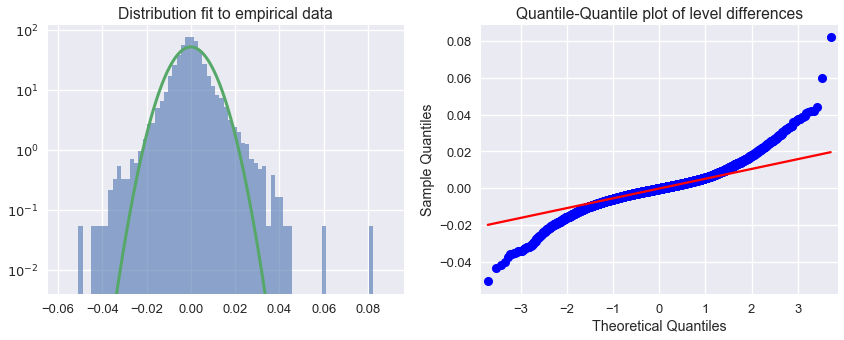

In [246]:
import scipy.stats as stats

dist = stats.norm

# lets try a t distribution first
m, s = dist.fit(e) # get mean and standard deviation  
print(m,s)

def nplot(m=0,s=0.004):
    print("Location = ",round(100*m,3),"centimeters")
    print("Scale = ",round(100*s,3),"centimeters")

    # histogram
    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(121)
    e.hist(bins = round((0.5*e.size)**0.5),normed=1,alpha=0.6,ax=ax1)
    plt.yscale('log')

    # plot pdf
    lnspc = np.linspace(plt.xlim()[0], plt.xlim()[1], len(e))
    pdf_g = dist.pdf(lnspc, m, s) # now get theoretical values in our interval  
    ax1.plot(lnspc, pdf_g, label="Norm",lw=3) # plot it
    plt.title('Distribution fit to empirical data')
    plt.ylim(0.004,122.0)

    # qq plot
    ax2 = fig.add_subplot(122)
    sm.qqplot(e,dist,loc=m,scale=s,ax=ax2,line='q');
    plt.title('Quantile-Quantile plot of level differences')

    plt.tight_layout()

nplot(m,s)

We can see that a Normal distribution seriously underestimates the frequency of large events.

#### Fitting a t-distribution.

In [243]:
import scipy.stats as stats

dist = stats.t

# lets try a t distribution first
df, m, s = dist.fit(e,10) # get mean and standard deviation  

Degrees of Freedom =  2.88
Location =  -0.0 centimeters
Scale =  0.481 centimeters
(0.0044231598919492543, 122.23181611857309)


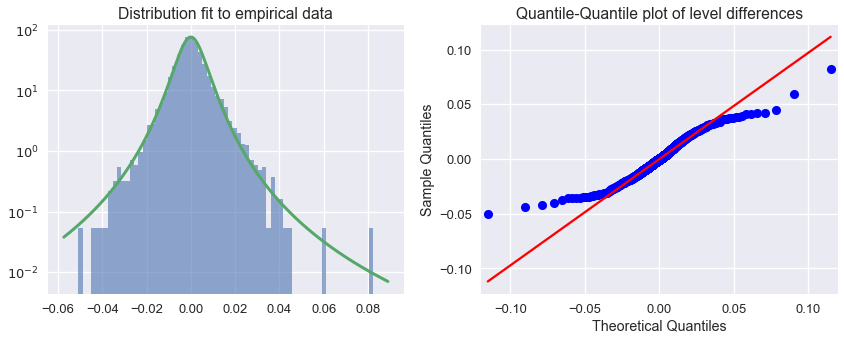

In [244]:
from ipywidgets import interact

def tplot(df=10,m=0,s=0.004):
    print("Degrees of Freedom = ",round(df,2))
    print("Location = ",round(100*m,3),"centimeters")
    print("Scale = ",round(100*s,3),"centimeters")

    # histogram
    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(121)
    e.hist(bins = round((0.5*e.size)**0.5),normed=1,alpha=0.6,ax=ax1)
    plt.yscale('log')

    # plot pdf
    lnspc = np.linspace(plt.xlim()[0], plt.xlim()[1], len(e))
    pdf_g = dist.pdf(lnspc, df, m, s) # now get theoretical values in our interval  
    ax1.plot(lnspc, pdf_g, label="Norm",lw=3) # plot it
    plt.title('Distribution fit to empirical data')
    print(plt.ylim())

    # qq plot
    ax2 = fig.add_subplot(122)
    sm.qqplot(e,dist,distargs=(df,),loc=m,scale=s,ax=ax2,line='q');
    plt.title('Quantile-Quantile plot of level differences')

    plt.tight_layout()

tplot(df,m,s)


### Summary

To summarize, the difference in lake level measurements at the two locations, Fort Frances and Bears Pass, is described by the difference equation

$$d(k) = 0.00481 \frac{1 - 0.4285B - 0.335B^2}{1 - 1.0689B + 0.0944B^2} e(k)$$

where $B$ is the backwards difference operator, and $e(k)$ is an i.i.d. disturbance with a distribution similar to a Student's t distribution with $\nu$ = 4.1 degrees of freedom

The availability of two sensors provides an opportunity to estimate the distribution of the level measurement noise. 

We assume the measurement data at the two locations is given by

\begin{align*}
y_1(k) & = h_1(k) + e_1(k) \\
y_2(k) & = h_2(k) + e_2(k)
\end{align*}

where $e_1(k)$ and $e_2(k)$ are the measurement errors on day $k$. 

Although the sensors are located on the same body of water, they are approximately 27 km apart therefore introducing the possibility of sustained differences due to hydrology, persistent wind or water flow patterns, or systematic measurement bias. For those reasons, we model the difference as w

\begin{align*}
d(k) & = y_2(k) - y_1(k) \\
& = \underbrace{h_2(k)-h_1(k)}_{\delta(k)} + \underbrace{e_2(k)-e_1(k)}_{\epsilon(k)}
\end{align*}

where we will assume $\delta(k) = h_2(k)-h_1(k)$ is a random variate associated with the dynamics of lake level, and $\epsilon(k) = e_2(k)-e_1(k)$ is a difference in measurement errors.

The presence of significant autocorrelation suggests an auto-regressive (AR) or an auto-regressive-moving-average (ARMA) model of the form

$$d(k+1) = \alpha d(k) + w(k)$$

\begin{align*}
d(k) & = y_2(k) - y_1(k) \\
& = \underbrace{h_2(k)-h_1(k)}_{\delta(k)} + \underbrace{e_2(k)-e_1(k)}_{\epsilon(k)}
\end{align*}

$$\delta(k+1) = \alpha\delta(k) + w(k)$$

Then 

\begin{align*}
d(k+1) & = \delta(k+1) + e_2(k+1) - e_1(k+1)\\
& = \alpha\delta(k) + w(k) + e_2(k+1) - e_1(k+1) \\
& = \alpha(d(k) - e_2(k) + e_1(k)) + w(k) + e_2(k+1) - e_1(k+1) \\
& = \alpha d(k) + [e_2(k+1)-\alpha e_2(k)] - [e_1(k+1)-\alpha e_1(k)] + w(k)
\end{align*}

$$d(k) = \delta(k) + e_2(k) - e_1(k)$$

5.77879983669e-20 0.00808277400447


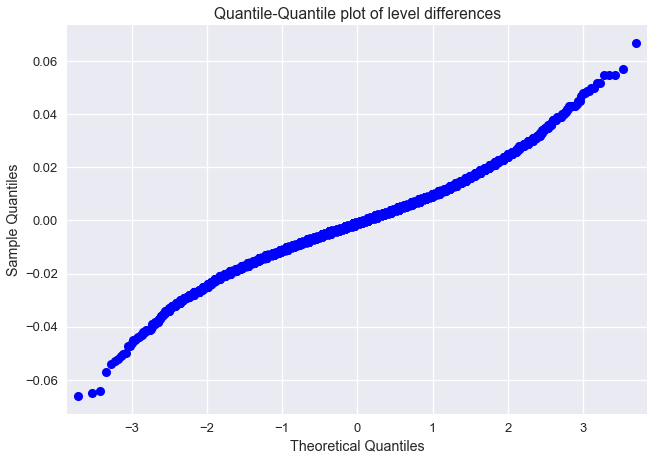

In [175]:
import statsmodels.api as sm
import scipy.stats as stats

m,s = stats.norm.fit(e) # get mean and standard deviation  

sm.qqplot(dR,stats.norm,loc=m,scale=s);
plt.title('Quantile-Quantile plot of level differences')
print(m,s)

$$d(k+1) = \delta(k+1) + e_2(k+1)-e_1(k+1)$$
$$d(k) = \delta(k) + e_2(k)-e_1(k)$$



Mean =  0.16 centimeters
Standard Deviation =  1.16 centimeters


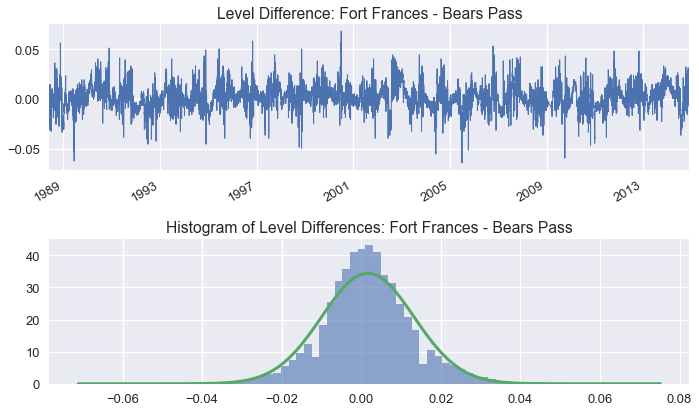

In [44]:
dR = BP - WSC_LEVELS[ff]
dR = dR[dR.notnull()]

# Statistics
mu = dR.mean();
sigma = dR.std();
print('Mean = ', round(100*mu,2), 'centimeters')
print('Standard Deviation = ', round(100*sigma,2), 'centimeters')

# Time series plot of the differences between sensors
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
dR.plot(lw=1)
plt.title('Level Difference: Fort Frances - Bear''s Pass')

# Compare empirical and fitted distributions
plt.subplot(2,1,2)
dR.hist(bins = round((0.5*dR.size)**0.5),normed=1,alpha=0.6)
plt.title('Histogram of Level Differences: Fort Frances - Bear''s Pass')
ax = plt.axis()
r = np.linspace(ax[0],ax[1],100)
p = [np.exp(-0.5*((x-mu)/sigma)**2)/(sigma*(2*np.pi)**0.5) for x in r]
plt.plot(r,p,linewidth=3)

plt.tight_layout()

This distribution is clearly has a narrower central distribution and somewhat longer tails than expressed by a fitted Normal distribution. This is verified by a QQ plot as shown in the next cell.

We will assume the measurement errors have identical statistics, but that there may be a systematic error such that difference $e_2(k)-e_1(k)$ is not necessarily zero-mean. The measureme

\begin{align*}
e_1(k+1) & = a e_1(k) + \epsilon_1(k) \\
e_2(k+1) & = a e_2(k) + \epsilon_2(k) + \delta
\end{align*}

w


\begin{align*}
d(k) & = y_2(k) - y_1(k) \\
\end{align*}